In [1]:
from ModularCirc.Models.NaghaviModel import NaghaviModel, NaghaviModelParameters
from ModularCirc.Solver import Solver

import ModularCirc.HelperRoutines as hr

import ModularCirc.StateVariable as sv
import matplotlib.pyplot as plt
import numpy  as np

Define the duration of the simulation in terms of the number of cycles, the duration of a time cycle (ms) and the duration of a time step.

In [2]:
TEMPLATE_TIME_SETUP_DICT = {
    'name'    :  'TimeTest',
    'ncycles' :  30,
    'tcycle'  :  800.,
    'dt'      :  1.0,
    'export_min' : 1
 }

The parameters object used to constrain the model.

In [3]:
parobj = NaghaviModelParameters()
parobj.set_chamber_comp('la', td=200.)
parobj.set_chamber_comp('lv', td=400.)

parobj.set_valve_comp('mv', max_func=hr.softplus)


Define an instance of the model using the parameter object.

In [4]:
model = NaghaviModel(TEMPLATE_TIME_SETUP_DICT, parobj=parobj)

Naghavi Model parameters set: 
 * Component - ao
  - r       : 3.200e+04
  - c       : 2.500e-03
  - l       : 0.000e+00
  - v_ref   : 1.000e+02
  - v       : 1.300e+02
  - p       : nan

 * Component - art
  - r       : 1.500e+05
  - c       : 2.500e-02
  - l       : 0.000e+00
  - v_ref   : 5.000e+01
  - v       : 1.300e+02
  - p       : nan

 * Component - ven
  - r       : 1.200e+03
  - c       : 1.000e+00
  - l       : 0.000e+00
  - v_ref   : 2.800e+03
  - v       : 3.780e+03
  - p       : nan

 * Component - av
  - r       : 8.000e+02
  - max_func : <function relu_max at 0x16935b010>

 * Component - mv
  - r       : 5.500e+02
  - max_func : <function softplus at 0x16935b2e0>

 * Component - la
  - E_pas   : 6.000e+01
  - E_act   : 5.867e+01
  - v_ref   : 1.000e+01
  - activation_function : <function activation_function_2 at 0x16935bc70>
  - tr      : 1.500e+02
  - td      : 2.000e+02
  - delay   : 1.000e+02
  - v       : 9.360e+01
  - p       : nan

 * Component - lv
  - E_pas   :

Define a solver to run the model.

In [5]:
solver = Solver(model=model)
solver.setup()

 -- Variable v_ao added to the principal variable key list.
    - name of update function: chamber_volume_rate_change
    - inputs: ['q_av', 'q_ao']
 -- Variable v_art added to the principal variable key list.
    - name of update function: chamber_volume_rate_change
    - inputs: ['q_ao', 'q_art']
 -- Variable v_ven added to the principal variable key list.
    - name of update function: chamber_volume_rate_change
    - inputs: ['q_art', 'q_ven']
 -- Variable v_la added to the principal variable key list.
    - name of update function: chamber_volume_rate_change
    - inputs: ['q_ven', 'q_mv']
 -- Variable v_lv added to the principal variable key list.
    - name of update function: chamber_volume_rate_change
    - inputs: ['q_mv', 'q_av']
 -- Variable p_lv added to the principal variable key list.
    - name of update function: self.comp_dpdt
    - inputs: ['v_lv', 'q_mv', 'q_av']
 -- Variable q_av added to the secondary variable key list.
    - name of update function: non_ideal_dio

In [6]:
# %prun -l 40 -s cumtime solver.solve()
# %prun -l 40 solver.solve()
solver.solve()

In [7]:
ind1 = -2*model.time_object.n_c+1
ind2 = -1

v_lv = solver.model.commponents['lv'].V.values[ind1:ind2]
p_lv = solver.model.commponents['lv'].P_i.values[ind1:ind2]

v_la = solver.model.commponents['la'].V.values[ind1:ind2]
p_la = solver.model.commponents['la'].P_i.values[ind1:ind2]

p_art = solver.model.commponents['art'].P_i.values[ind1:ind2]
p_ven = solver.model.commponents['ven'].P_i.values[ind1:ind2]

t = model.time_object._sym_t[ind1:ind2].values
t -= t[0]

q_mv = solver.model.commponents['mv'].Q_i.values[ind1:ind2]
q_av = solver.model.commponents['av'].Q_i.values[ind1:ind2]
p_ao = solver.model.commponents['ao'].P_i.values[ind1:ind2]
q_ao = solver.model.commponents['ao'].Q_o.values[ind1:ind2]

af_lv = np.vectorize(model.commponents['lv']._af) 
af_la = np.vectorize(model.commponents['la']._af) 
tc = model.time_object._cycle_t[ind1:ind2]

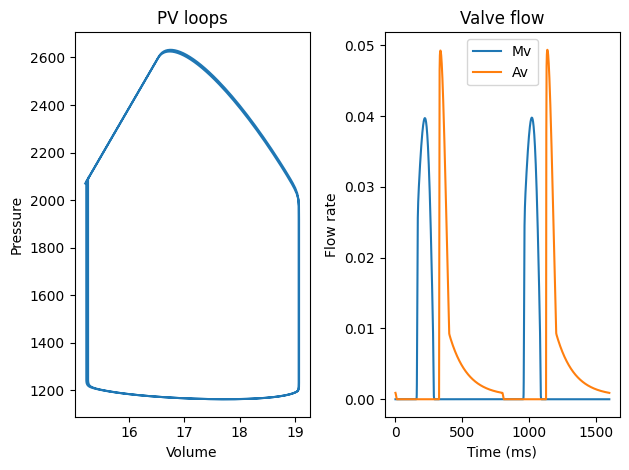

In [8]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(v_lv, p_lv)
ax[0].set_title('PV loops')
ax[0].set_ylabel('Pressure')
ax[0].set_xlabel('Volume')

ax[1].plot(t, q_mv, label='Mv')
ax[1].plot(t, q_av, label='Av')
ax[1].set_title('Valve flow')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Flow rate')
ax[1].legend()

plt.tight_layout()
plt.show()

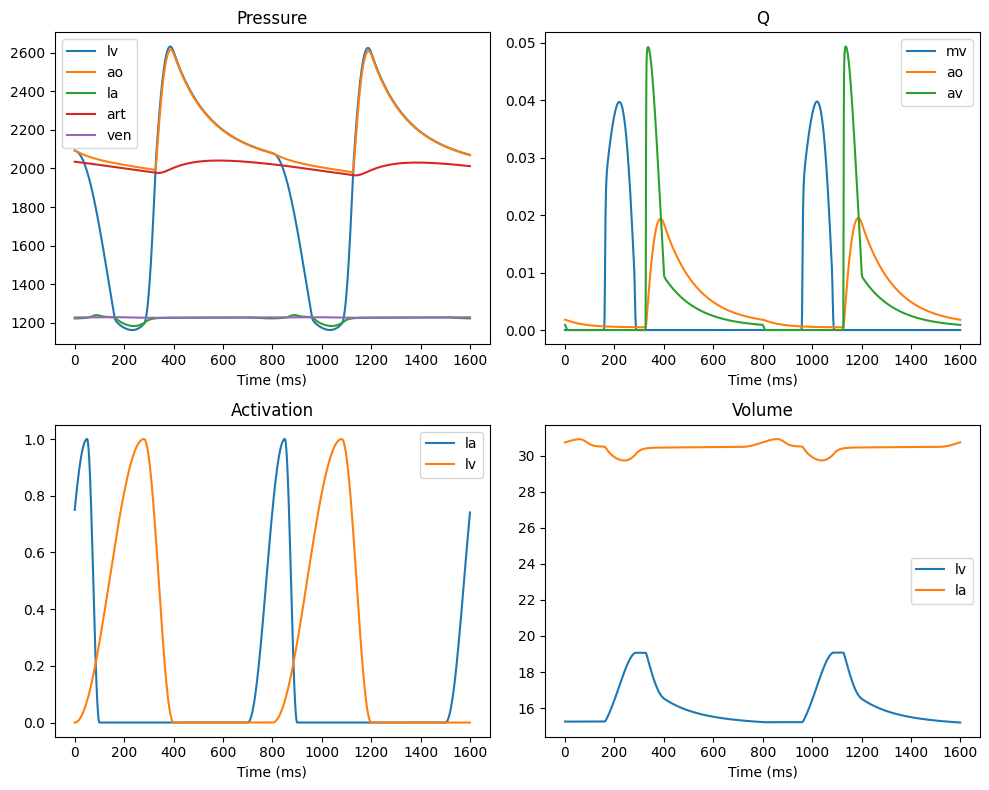

In [9]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

ax2[0][0].plot(t, p_lv, label='lv')
ax2[0][0].plot(t, p_ao, label='ao')
ax2[0][0].plot(t, p_la, label='la')
ax2[0][0].plot(t, p_art, label='art')
ax2[0][0].plot(t, p_ven, label='ven')
ax2[0][0].set_title('Pressure')
ax2[0][0].set_xlabel('Time (ms)')
ax2[0][0].legend()

ax2[0][1].plot(t, q_mv, label='mv')
ax2[0][1].plot(t, q_ao, label='ao')
ax2[0][1].plot(t, q_av, label='av')
ax2[0][1].set_title('Q')
ax2[0][1].set_xlabel('Time (ms)')
ax2[0][1].legend()

ax2[1][0].plot(t, af_la(tc), label='la')
ax2[1][0].plot(t, af_lv(tc), label='lv')
ax2[1][0].set_title('Activation')
ax2[1][0].set_xlabel('Time (ms)')
ax2[1][0].legend()

ax2[1][1].plot(t, v_lv, label='lv')
ax2[1][1].plot(t, v_la, label='la')
ax2[1][1].set_title('Volume')
ax2[1][1].set_xlabel('Time (ms)')
ax2[1][1].legend()

plt.tight_layout()
plt.show()